In [3]:
from fastai.vision.all import *

In [4]:
path = untar_data(URLs.MNIST_SAMPLE) #path to a local MNIST library
#(path/'train').ls() 
(path).ls() #path contains mnist_sample folder, which has a csv file, train and valid folders

(#3) [Path('C:/Users/kulik/.fastai/data/mnist_sample/labels.csv'),Path('C:/Users/kulik/.fastai/data/mnist_sample/train'),Path('C:/Users/kulik/.fastai/data/mnist_sample/valid')]

In [5]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
#threes

In [6]:
#output an image of 3
img3_path = threes[6]
img3 = Image.open(img3_path)

img3

In [7]:
#translate an image to tensor, so that computer will understand what is it
img3_t = tensor(img3)

df = pd.DataFrame(img3_t[4:15,4:22]) #plot one region
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys') #plot with grey colors

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,61,177,254,255,153,118,118,118,6,0,0,0,0
2,0,71,234,234,234,244,253,253,253,253,253,253,253,179,66,0,0,0
3,0,191,253,253,253,214,177,177,239,253,253,253,253,253,170,0,0,0
4,0,109,181,61,61,30,0,0,50,61,150,229,253,253,233,41,0,0
5,0,25,20,0,0,0,0,0,0,0,0,144,253,253,253,54,0,0
6,0,0,0,0,0,0,0,0,0,0,9,150,253,253,204,22,0,0
7,0,0,0,0,0,0,0,0,0,97,210,253,253,253,170,0,0,0
8,0,0,0,0,0,0,108,233,248,252,253,253,253,208,22,0,0,0
9,0,0,0,0,5,160,253,253,253,253,253,253,253,186,12,0,0,0


In [8]:
# FINDING AVERAGE VALUE OF ENTIRE FOLDER OF 3's AND 7's

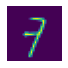

In [9]:
# create a list of tensors (hard way)
# three_tensors = []
# for i in threes:
#     three_tensors.append(tensor(Image.open(i)))


# create a list of tensors (easy, list comprehension, way)
three_tensors = [tensor(Image.open(o)) for o in threes]
seven_tensors = [tensor(Image.open(o)) for o in sevens]

show_image(seven_tensors[100]);

In [10]:
#stacking all images into one big tensor
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255

stacked_threes.shape, stacked_sevens.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

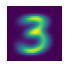

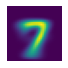

In [11]:
mean3 = stacked_threes.mean(0)
mean7 = stacked_sevens.mean(0)
show_image(mean3);
show_image(mean7);

In [12]:
#pick a random 3, and compare it to ideal 3
a_3 = stacked_threes[1010]

dist_3_abs = (a_3 - mean3).abs().mean() #mean absolute difference, L1 norm
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt() #root mean squared error, L2 norm

print('L1 norm is: {}, L2 norm is: {}'.format(dist_3_abs,dist_3_sqr))

L1 norm is: 0.12162479013204575, L2 norm is: 0.2195712924003601


In [13]:
#using PyTorch built in methods
F.l1_loss(a_3.float(),mean3), F.mse_loss(a_3,mean3).sqrt()

(tensor(0.1216), tensor(0.2196))

In [14]:
#validation set

In [15]:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255

valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255

valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [16]:
#function that compares an tensor with an ideal tensor
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
#(a-b).abs()    - absolute value of the difference between ideal tensor and the tensor of comparison
#.mean((-1,-2)) - -1 is the last axis, -2 is second to last. Here we averaged the intensity of all the pixels in one image

mnist_distance(a_3, mean3)

tensor(0.1216)

In [17]:
#validate results of out model with images from validation set
valid_3_dist = mnist_distance(valid_3_tens, mean3)
#PyTorch automatically applies broadcasting, 
#pretending that mean3(28,28) is a shape 1010 tensor, and (valid_3_tens - mean3) has the shape [1010,28,28]

valid_3_dist, valid_3_dist.shape

(tensor([0.1280, 0.1623, 0.1242,  ..., 0.1508, 0.1263, 0.1260]),
 torch.Size([1010]))

In [18]:
#return 'is 3' is distance of 
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [19]:
#calculate accuracy
accuracy_3s = is_3(valid_3_tens).float() .mean()      #output True if a tensor is 3, transfer to boolean, calculate mean
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean() #same as previous, 1- is for switching results

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

In [20]:
#---------- MNIST Loss Function ----------#

In [21]:
# concatenate all images into a rank-2 tensor  
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

# labels for each image
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)

train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [22]:
# mash together an image with it's label
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

In [23]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [24]:
# initially random weigths for every pixel
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()
weights = init_params((28*28,1))

# initiallize bias
bias = init_params(1)

In [25]:
# calculate prediction
(train_x[0]*weights.T).sum() + bias

tensor([19.6967], grad_fn=<AddBackward0>)

In [26]:
# calculate prediction for all images using matrix multiplication
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds[0:10]

tensor([[19.6967],
        [13.3970],
        [22.8870],
        [20.0755],
        [12.8444],
        [28.5660],
        [24.1983],
        [20.0878],
        [24.4820],
        [20.4526]], grad_fn=<SliceBackward>)

In [27]:
# check accuracy 
corrects = (preds>0.0).float() == train_y
print("Accuracy is {0: .2f}%".format(corrects.float().mean().item()))

Accuracy is  0.53%
